# Promo & Discount Effectiveness Analysis  
### Increasing GMV Without Killing Margin

**Role context:** Senior Data Analyst  
**Tools:** DuckDB (SQL), Python  
**Dataset:** Sample Superstore (public dataset)

This analysis evaluates how different discount depths impact GMV, margin, and customer behavior, 
with the goal of identifying promotion strategies that drive sustainable growth.


## 0️⃣ Executive Summary
This analysis evaluates the effectiveness of discount strategies in driving GMV while protecting profitability.

Key findings show that nearly half of total GMV is generated without any discount and delivers the highest margin.
Aggressive discounts above 20% fail to increase basket size and significantly erode profitability, even among returning customers.

The analysis recommends prioritizing non-discount growth, scaling low discounts selectively, and restricting deep discounts to controlled clearance use cases.


## 1️⃣ Business Context & Question
Discounts are commonly used to stimulate demand and grow GMV.
However, excessive discounting may increase revenue at the expense of margin and long-term sustainability.

Business Question:
Which discount levels increase GMV without materially hurting margin?


## 2️⃣ Data Preparation (SQL via DuckDB)

In [1]:
import kagglehub
import shutil
import os

# 1. Tentukan folder tujuan 
target_dir = r"C:\Users\yohan\workstation\fore\Promo Effectiveness Analysis"

# 2. Buat folder jika belum 
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# 3. Download dataset (ke folder cache sementara)
temp_path = kagglehub.dataset_download("vivek468/superstore-dataset-final")

# 4. Memindahkan isi file dari cache ke folder tujuan
# ambil semua file di temp_path dan pindahkan ke target_dir
files = os.listdir(temp_path)
for f in files:
    src_path = os.path.join(temp_path, f)
    dst_path = os.path.join(target_dir, f)
    
    # copy/move (shutil.move akan menghapus di cache asli)
    shutil.copy(src_path, dst_path)

print(f"Dataset berhasil dipindahkan ke: {target_dir}")

Dataset berhasil dipindahkan ke: C:\Users\yohan\workstation\fore\Promo Effectiveness Analysis


In [2]:
import pandas as pd
import os

path_folder = r"C:\Users\yohan\workstation\fore\Promo Effectiveness Analysis"
files = os.listdir(path_folder)
file_target = next((f for f in files if f.endswith('.csv')), None)

if file_target:
    full_path = os.path.join(path_folder, file_target)
    
    try:
        # Percobaan 1: utf-8 (default)
        df = pd.read_csv(full_path)
    except UnicodeDecodeError:
        try:
            # Percobaan 2: latin1 (umum untuk file Windows/Excel)
            print("UTF-8 gagal, mencoba encoding latin1...")
            df = pd.read_csv(full_path, encoding='latin1')
        except UnicodeDecodeError:
            # Percobaan 3: ISO-8859-1
            print("latin1 gagal, mencoba encoding ISO-8859-1...")
            df = pd.read_csv(full_path, encoding='ISO-8859-1')

    print(f"\nDataFrame '{file_target}' berhasil dimuat!")
    print(df.head())
    
    # Simpan dataframe ke variabel global untuk analisis selanjutnya
    # %store df # Jika di Jupyter, ini berguna
else:
    print("\nTidak ada file CSV yang ditemukan.")

UTF-8 gagal, mencoba encoding latin1...

DataFrame 'Sample - Superstore.csv' berhasil dimuat!
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [8]:
import duckdb
query = """
SELECT
    "Order Date" as ORDER_DATE,
    "Customer ID" as CUSTOMER_ID,
    Discount as DISCOUNT,
    sales as SALES,
    profit as PROFIT,
    quantity as QUANTITY,
    CASE
        WHEN discount = 0 THEN 'No Discount'
        WHEN discount <= 0.10 THEN 'Low (0–10%)'
        WHEN discount <= 0.20 THEN 'Medium (10–20%)'
        ELSE 'High (>20%)'
    END AS DISCOUNT_BUCKET
FROM df
"""
# Execute the query in DuckDB
data_prep = duckdb.query(query).to_df()
data_prep.head(3)

,ORDER_DATE,CUSTOMER_ID,DISCOUNT,SALES,PROFIT,QUANTITY,DISCOUNT_BUCKET
0,11/8/2016,CG-12520,0.0,261.96,41.9136,2,No Discount
1,11/8/2016,CG-12520,0.0,731.94,219.5820,3,No Discount
2,6/12/2016,DV-13045,0.0,14.62,6.8714,2,No Discount


## 3️⃣ Baseline Performance by Discount Bucket

In [19]:
query = """
SELECT
    DISCOUNT_BUCKET,
    ROUND(SUM(SALES),2) AS GMV,
    ROUND(SUM(PROFIT),2) AS PROFIT,
    ROUND(SUM(PROFIT) / SUM(SALES) * 100, 2) AS MARGIN_PCT
FROM data_prep
GROUP BY DISCOUNT_BUCKET
ORDER BY MARGIN_PCT DESC
"""
baseline_discount = duckdb.query(query).to_df()
baseline_discount

,DISCOUNT_BUCKET,GMV,PROFIT,MARGIN_PCT
0,No Discount,1087908.47,320987.60,29.51
1,Low (0–10%),54369.35,9029.18,16.61
2,Medium (10–20%),792152.89,91756.30,11.58
3,High (>20%),362770.15,-135376.06,-37.32


### Insight

No-discount transactions generate the highest GMV and margin (≈30%).
Low discounts remain profitable while medium discounts significantly compress margin.
High discounts destroy profitability, producing negative margins despite sizable GMV.

Discount depth is the strongest driver of margin erosion.


## 4️⃣ GMV Distribution vs Margin (Scale Check)

In [15]:
query = """
SELECT
    DISCOUNT_BUCKET,
    ROUND(SUM(SALES), 2) AS GMV,
    ROUND(SUM(SALES) / SUM(SUM(SALES)) OVER () * 100, 2) AS GMV_SHARE_PCT,
    ROUND(SUM(PROFIT) / SUM(SALES) * 100, 2) AS MARGIN_PCT
FROM data_prep
GROUP BY DISCOUNT_BUCKET
ORDER BY GMV DESC
"""
gmv_share = duckdb.query(query).to_df()
gmv_share

,DISCOUNT_BUCKET,GMV,GMV_SHARE_PCT,MARGIN_PCT
0,No Discount,1087908.47,47.36,29.51
1,Medium (10–20%),792152.89,34.48,11.58
2,High (>20%),362770.15,15.79,-37.32
3,Low (0–10%),54369.35,2.37,16.61


### Insight
Nearly 47% of total GMV comes from non-discounted transactions with the healthiest margin.
Medium discounts contribute significant GMV share but at much lower profitability.
High discounts contribute meaningful GMV but are economically unsustainable.

Low discounts remain underutilized relative to their margin performance.


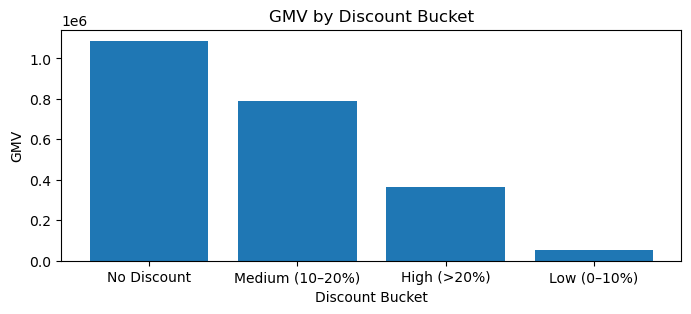

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.bar(gmv_share['DISCOUNT_BUCKET'], gmv_share['GMV'])
plt.title('GMV by Discount Bucket')
plt.ylabel('GMV')
plt.xlabel('Discount Bucket')
plt.show()

### Insight
Nearly half of GMV is generated without discounts.
Medium discounts contribute significant GMV but at much lower profitability.


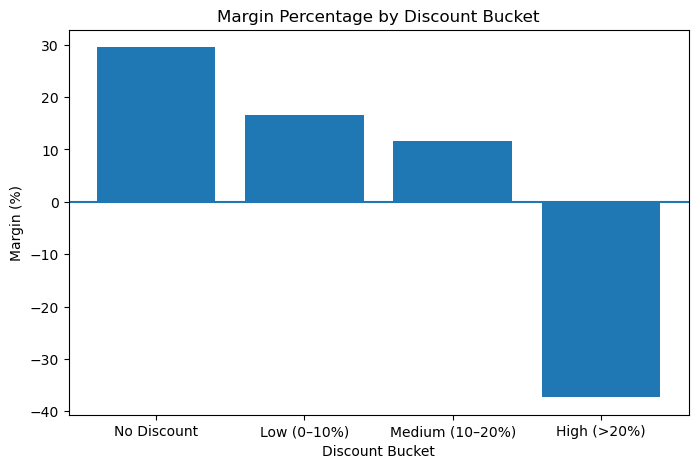

In [35]:
plt.figure(figsize=(8,5))
plt.bar(baseline_discount['DISCOUNT_BUCKET'], baseline_discount['MARGIN_PCT'])
plt.title('Margin Percentage by Discount Bucket')
plt.ylabel('Margin (%)')
plt.xlabel('Discount Bucket')
plt.axhline(0)
plt.show()


### Insight
Margin declines sharply as discount depth increases.
High discounts result in structurally negative margins.



## 5️⃣ Basket Behavior Analysis

In [16]:
query = """
SELECT
    DISCOUNT_BUCKET,
    COUNT(DISTINCT CUSTOMER_ID) AS CUSTOMERS,
    ROUND(SUM(QUANTITY) / COUNT(DISTINCT CUSTOMER_ID), 2) AS QTY_PER_CUSTOMER,
    ROUND(SUM(SALES) / COUNT(DISTINCT CUSTOMER_ID), 2) AS SALES_PER_CUSTOMER
FROM data_prep
GROUP BY DISCOUNT_BUCKET
ORDER BY SALES_PER_CUSTOMER DESC
"""
basket_behavior = duckdb.query(query).to_df()
basket_behavior

,DISCOUNT_BUCKET,CUSTOMERS,QTY_PER_CUSTOMER,SALES_PER_CUSTOMER
0,No Discount,759,24.07,1433.34
1,Medium (10–20%),759,18.26,1043.68
2,High (>20%),565,9.51,642.07
3,Low (0–10%),85,4.39,639.64


### Insight
Customers purchase the largest baskets without discounts.
Higher discount levels do not increase basket size and instead reduce average spend per customer.
Aggressive discounting lowers price, not volume.

Discounts reduce price, not basket.


## 6️⃣ Customer Type Classification (New vs Returning)

In [23]:
# Identify First Purchase
query = """
SELECT
    CUSTOMER_ID,
    MIN(ORDER_DATE) AS FIRST_ORDER_DATE
FROM data_prep
GROUP BY CUSTOMER_ID
"""

first_order = duckdb.query(query).to_df()

# Enrich Customer Type
query = """
SELECT
    d.*,
    CASE
        WHEN d.ORDER_DATE = f.FIRST_ORDER_DATE THEN 'New'
        ELSE 'Returning'
    END AS CUSTOMER_TYPE
FROM data_prep d
JOIN first_order f
ON d.CUSTOMER_ID = f.CUSTOMER_ID
"""

customer_enriched = duckdb.query(query).to_df()

## 7️⃣ GMV & Margin by Discount and Customer Type

In [24]:
# Enrich Customer Type
query = """
SELECT
    DISCOUNT_BUCKET,
    CUSTOMER_TYPE,
    ROUND(SUM(SALES), 2) AS GMV,
    ROUND(SUM(PROFIT) / SUM(SALES) * 100, 2) AS MARGIN_PCT
FROM customer_enriched
GROUP BY DISCOUNT_BUCKET, CUSTOMER_TYPE
ORDER BY DISCOUNT_BUCKET, CUSTOMER_TYPE
"""

customer_type_analysis = duckdb.query(query).to_df()
customer_type_analysis

,DISCOUNT_BUCKET,CUSTOMER_TYPE,GMV,MARGIN_PCT
0,High (>20%),New,58840.41,-49.07
1,High (>20%),Returning,303929.74,-35.04
2,Low (0–10%),New,5202.68,21.47
3,Low (0–10%),Returning,49166.67,16.09
4,Medium (10–20%),New,137137.16,11.79
5,Medium (10–20%),Returning,655015.73,11.54
6,No Discount,New,231812.45,30.53
7,No Discount,Returning,856096.02,29.23


### Insight
High discounts fail to profitably acquire new customers and significantly erode margin for returning customers.
Medium discounts primarily benefit existing customers rather than driving acquisition.
No-discount transactions deliver the strongest profitability across both new and returning customers.

Customer acquisition does not require heavy discounting.


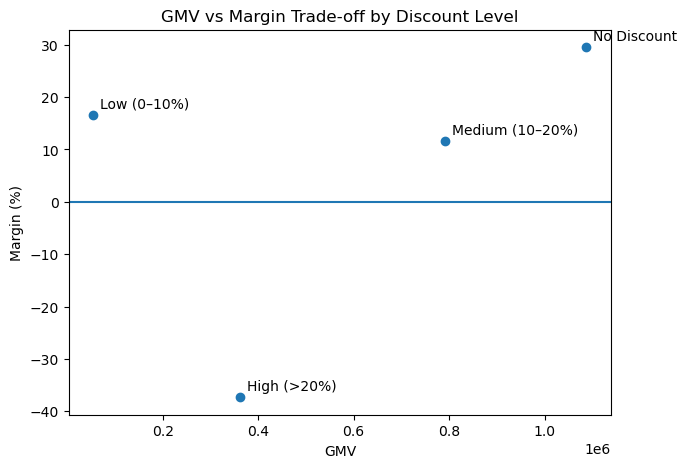

In [36]:
plt.figure(figsize=(7,5))
plt.scatter(
    baseline_discount['GMV'],
    baseline_discount['MARGIN_PCT']
)

for i, txt in enumerate(baseline_discount['DISCOUNT_BUCKET']):
    plt.annotate(
        txt,
        (baseline_discount['GMV'][i], baseline_discount['MARGIN_PCT'][i]),
        textcoords="offset points",
        xytext=(5,5)
    )

plt.title('GMV vs Margin Trade-off by Discount Level')
plt.xlabel('GMV')
plt.ylabel('Margin (%)')
plt.axhline(0)
plt.show()


### Insight
No-discount transactions sit in the optimal zone of high GMV and high margin.
High discounts occupy the worst trade-off zone: low margin despite sizable GMV.


## 8️⃣ Recommendation Framework
## Executive Summary

- 47% of total GMV is generated without any discount, delivering the highest margin (~30%).
- Discounts above 20% fail to increase basket size and result in severe margin erosion (-37%).
- Medium discounts (10–20%) drive volume but primarily benefit returning customers.
- Customer acquisition does not require aggressive discounting.
  
### Business Recommendations

- Prioritize non-discount growth as the primary revenue engine.
- Scale low discounts selectively to stimulate demand while protecting margin.
- Use medium discounts in targeted campaigns for existing customers.
- Restrict high discounts to controlled clearance scenarios only.

Discount strategy should be driven by profitability, not volume alone.


## 9️⃣ Why This Matters
This analysis demonstrates how pricing and promotion decisions directly impact GMV quality.
By shifting from aggressive discounting to targeted, margin-aware strategies, Fore can drive sustainable growth without sacrificing profitability.
